## Load Dataset

We begin by importing all necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from IPython.display import display

We load the dataset here and perform some basic EDA. There are no null values in the data as seen below

In [2]:
data = pd.read_csv('../input/Financial_inclusion_dataset.csv')
data.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [3]:
data.tail()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
23519,Uganda,2018,uniqueid_2113,No,Rural,Yes,4,48,Female,Head of Household,Divorced/Seperated,No formal education,Other Income
23520,Uganda,2018,uniqueid_2114,No,Rural,Yes,2,27,Female,Head of Household,Single/Never Married,Secondary education,Other Income
23521,Uganda,2018,uniqueid_2115,No,Rural,Yes,5,27,Female,Parent,Widowed,Primary education,Other Income
23522,Uganda,2018,uniqueid_2116,No,Urban,Yes,7,30,Female,Parent,Divorced/Seperated,Secondary education,Self employed
23523,Uganda,2018,uniqueid_2117,No,Rural,Yes,10,20,Male,Child,Single/Never Married,Secondary education,No Income


In [4]:
data.describe()

,year,household_size,age_of_respondent
count,23524.000000,23524.000000,23524.000000
mean,2016.975939,3.797483,38.805220
std,0.847371,2.227613,16.520569
min,2016.000000,1.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


In [5]:
## check for null values
(data.isna().sum() * 100 / data.isna().count()).map(lambda x: str(round(x, 2)) + '%')

country                   0.0%
year                      0.0%
uniqueid                  0.0%
bank_account              0.0%
location_type             0.0%
cellphone_access          0.0%
household_size            0.0%
age_of_respondent         0.0%
gender_of_respondent      0.0%
relationship_with_head    0.0%
marital_status            0.0%
education_level           0.0%
job_type                  0.0%
dtype: object

In [6]:
## can household size be categorized to improve model?
data.where(data['age_of_respondent'] == 100).dropna()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
14804,Tanzania,2017.0,uniqueid_2,No,Urban,No,2.0,100.0,Male,Head of Household,Single/Never Married,No formal education,Self employed
18698,Tanzania,2017.0,uniqueid_3896,No,Urban,No,5.0,100.0,Male,Parent,Widowed,Primary education,Government Dependent
20508,Tanzania,2017.0,uniqueid_5706,No,Rural,No,4.0,100.0,Female,Child,Widowed,No formal education,No Income
20727,Tanzania,2017.0,uniqueid_5925,No,Urban,No,3.0,100.0,Male,Head of Household,Single/Never Married,Primary education,Self employed
20945,Tanzania,2017.0,uniqueid_6143,No,Urban,No,2.0,100.0,Female,Head of Household,Widowed,No formal education,No Income


In [7]:
## let's get categorical and numerical columns

cat_cols = data.loc[:, data.dtypes == 'object'].columns
num_cols = data.loc[:, data.dtypes != 'object'].columns

num_cols

Index(['year', 'household_size', 'age_of_respondent'], dtype='object')

Let us perform some basic EDA. We check the distribution of numerical (continuous) and categorical (discrete) data.

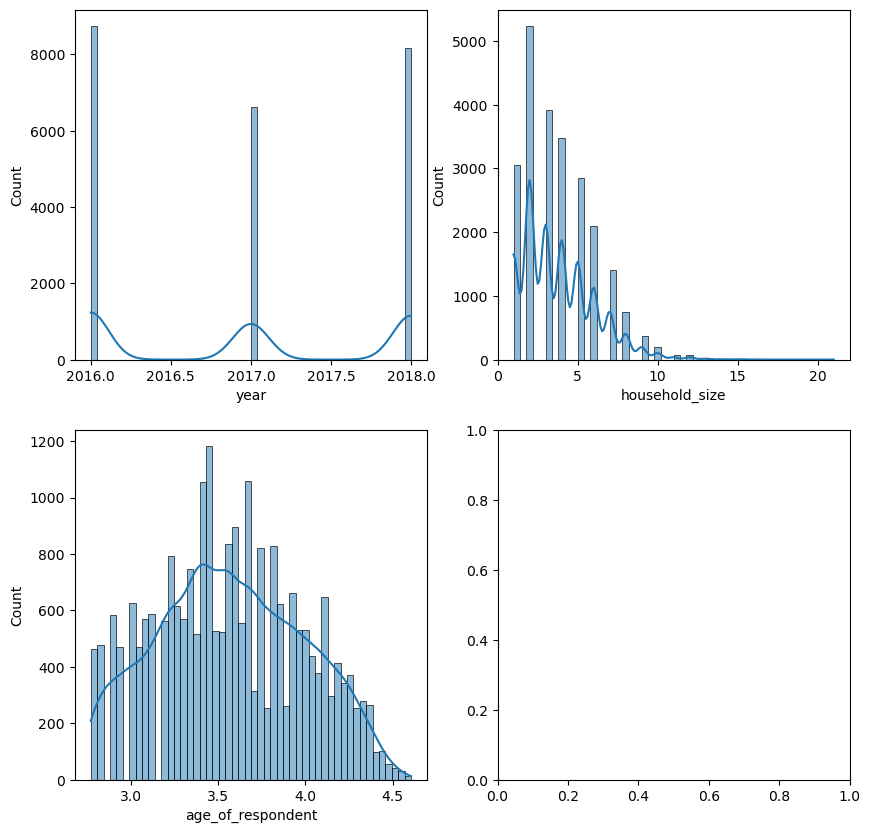

In [8]:
## let's perform an eda

## for numerical data
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, col in enumerate(num_cols):
    if i == len(num_cols)-1:
        sns.histplot(x=np.log(data[col]), bins=50, kde=True, ax=axs[i//2, i%2])
        break
        
    sns.histplot(data=data, x=col, bins=50, kde=True, ax=axs[i//2, i%2])

In [9]:
data['household_size'].nunique()

20

<AxesSubplot:xlabel='age_of_respondent', ylabel='Count'>

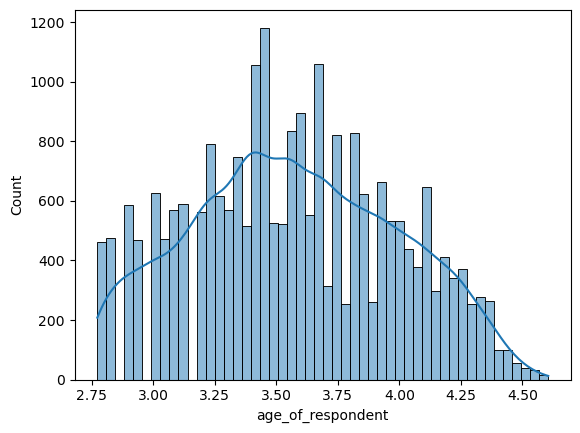

In [10]:
sns.histplot(np.log(data['age_of_respondent']), kde=True, bins=50)

In [11]:
## for the categorical columns
data[cat_cols].nunique()

country                      4
uniqueid                  8735
bank_account                 2
location_type                2
cellphone_access             2
gender_of_respondent         2
relationship_with_head       6
marital_status               5
education_level              6
job_type                    10
dtype: int64

In [12]:
## we are trying to get the names of the unique values here

for col in cat_cols.drop('uniqueid'):
    print(f'{col}:\t\t{data[col].unique()}')

country:		['Kenya' 'Rwanda' 'Tanzania' 'Uganda']
bank_account:		['Yes' 'No']
location_type:		['Rural' 'Urban']
cellphone_access:		['Yes' 'No']
gender_of_respondent:		['Female' 'Male']
relationship_with_head:		['Spouse' 'Head of Household' 'Other relative' 'Child' 'Parent'
 'Other non-relatives']
marital_status:		['Married/Living together' 'Widowed' 'Single/Never Married'
 'Divorced/Seperated' 'Dont know']
education_level:		['Secondary education' 'No formal education'
 'Vocational/Specialised training' 'Primary education'
 'Tertiary education' 'Other/Dont know/RTA']
job_type:		['Self employed' 'Government Dependent' 'Formally employed Private'
 'Informally employed' 'Formally employed Government'
 'Farming and Fishing' 'Remittance Dependent' 'Other Income'
 'Dont Know/Refuse to answer' 'No Income']


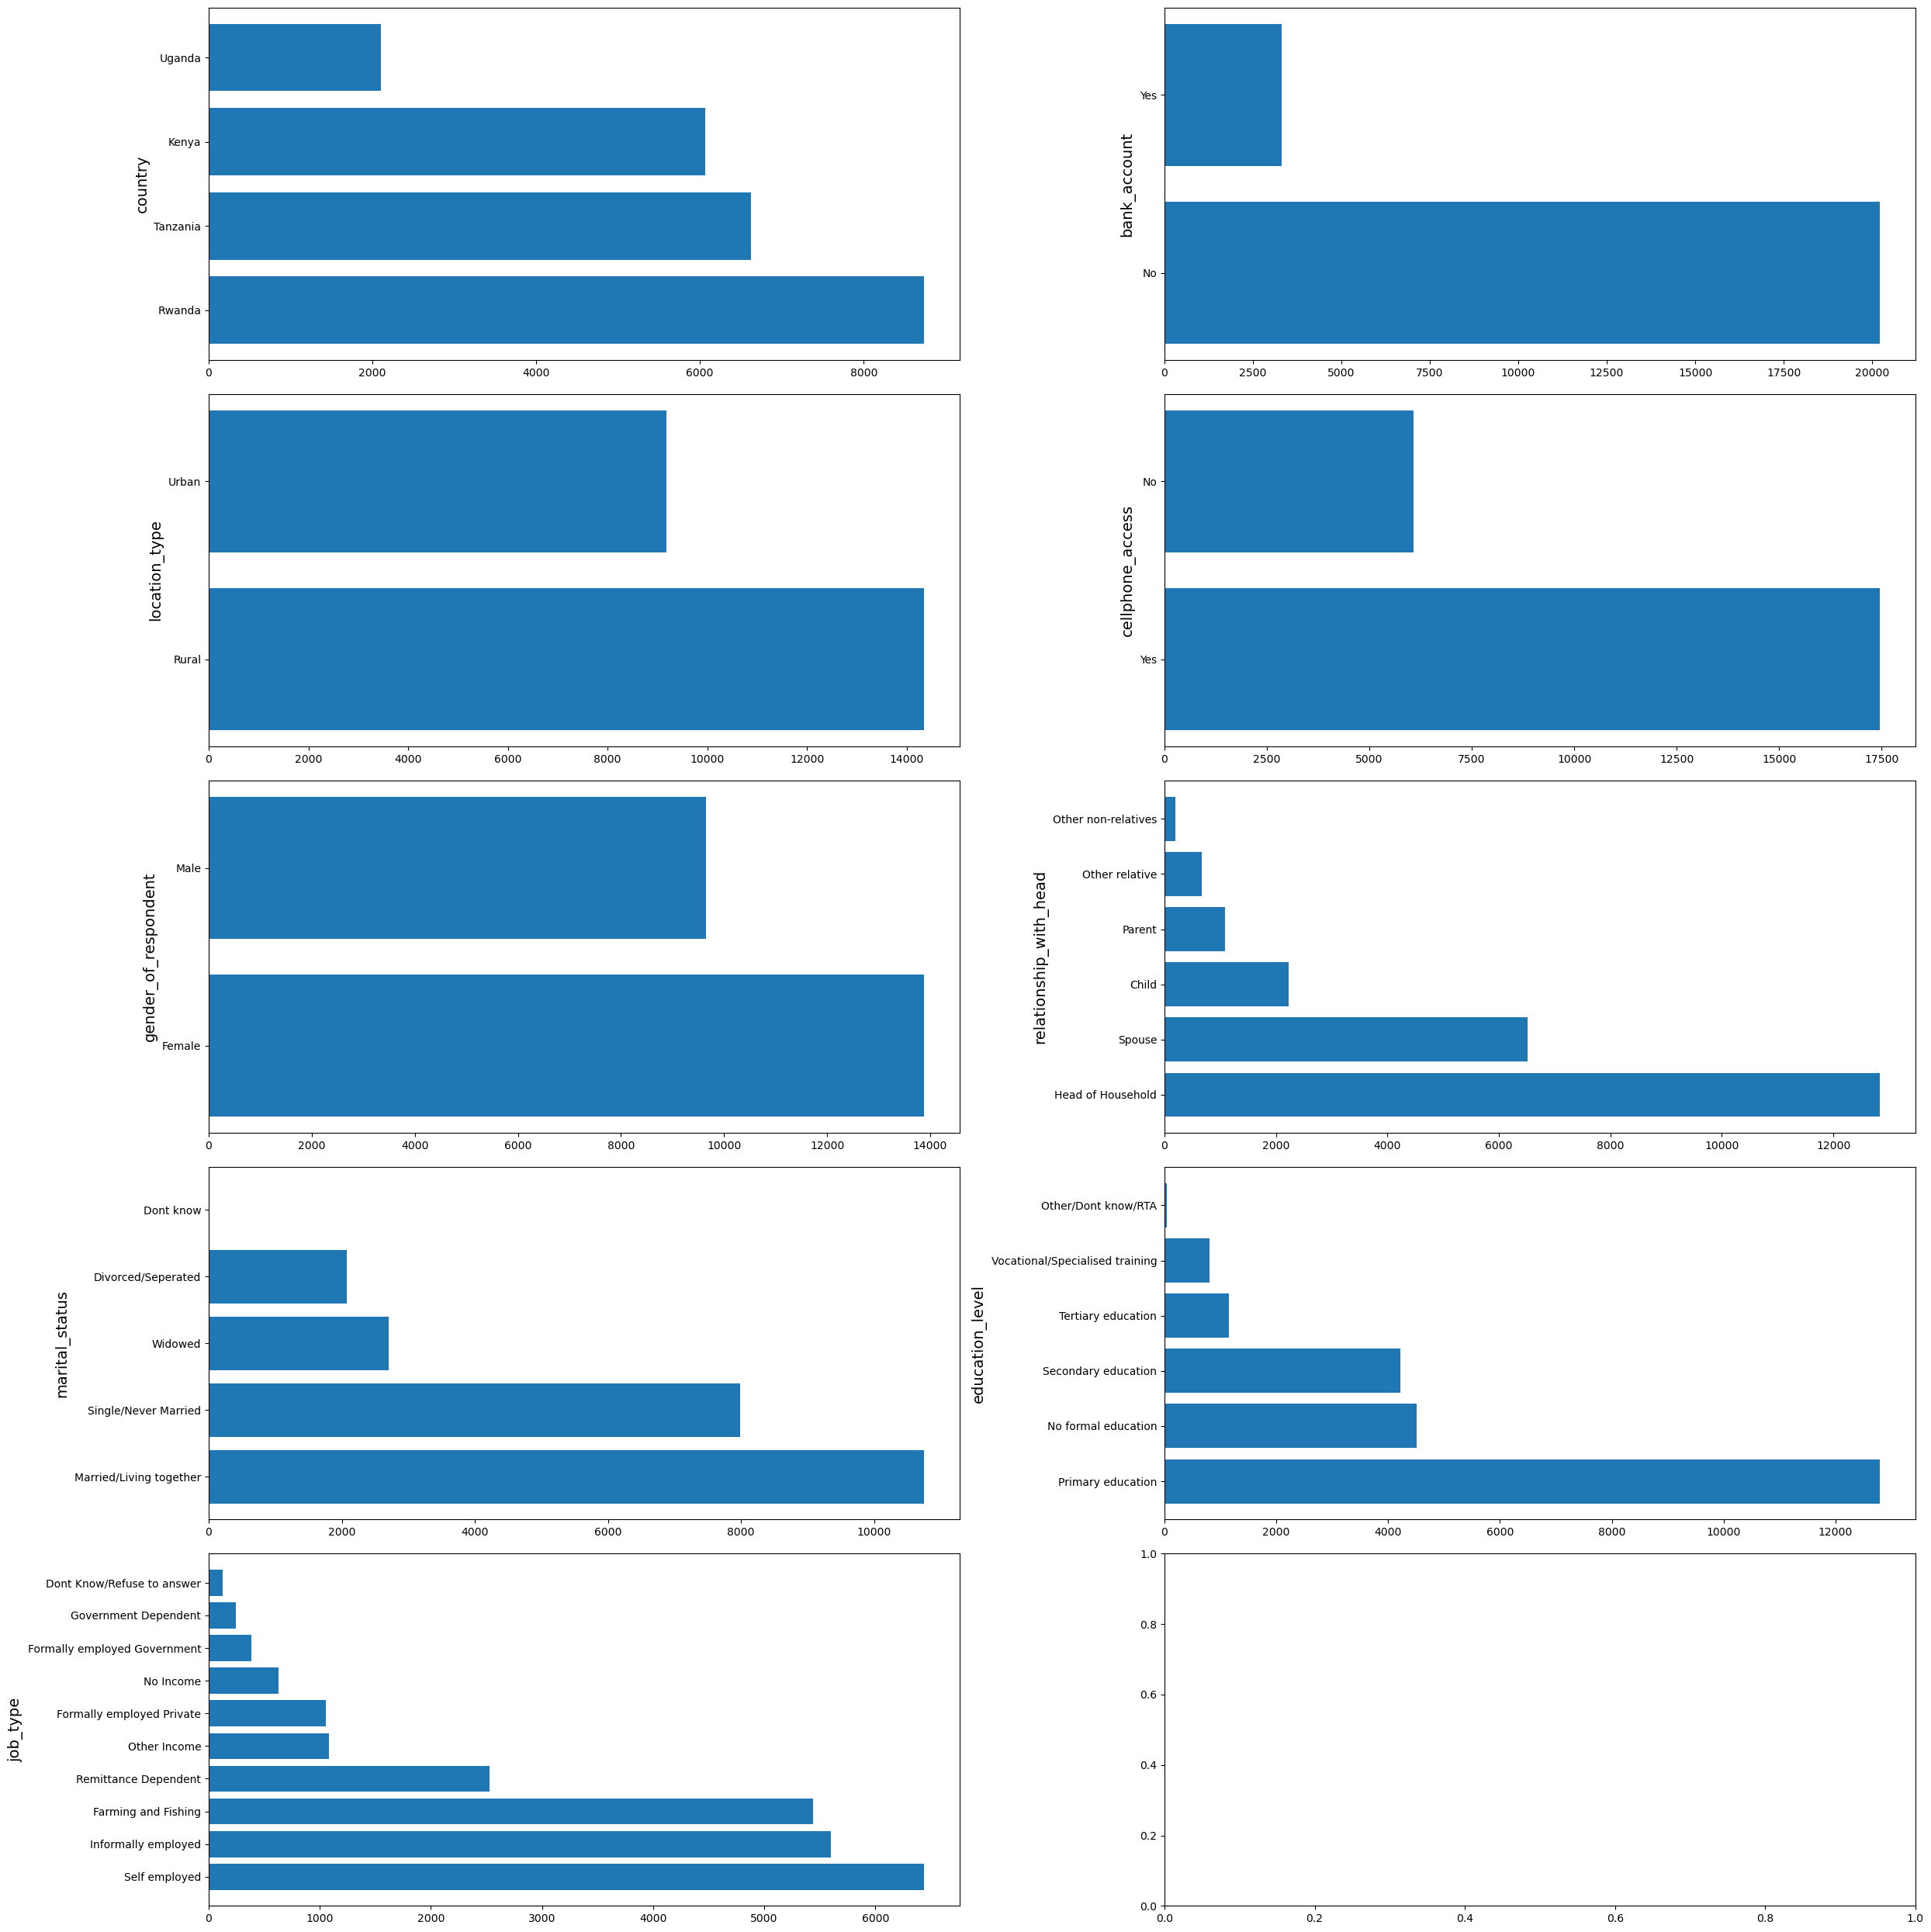

In [13]:
_ = cat_cols.drop('uniqueid')
fig, axs = plt.subplots((len(_) // 2)+1, 2, figsize=(25, 25))

for i, ax in enumerate(axs.flat):
    ax.barh(y=data[_[i]].value_counts().index, width=data[_[i]].value_counts())
    ax.set_ylabel(_[i], fontsize=14)
    
    if i == len(_)-1:
        break
        
plt.tight_layout()

In [14]:
# remember to drop uniqueid
## try to classify the household size numerical column

def feature_eng(X, y, num=None, cat=None, X_test=None, y_test=None):
    '''
    This function performs OneHotEncoding and OrdinalEncoding on the categorical section of the dataset.
    It also scales the numerical part of the dataset. This is of utmost importance for the logistic regression.
    '''
    
    if cat is not None or num is not None:
        if 'bank_account' in cat or 'uniqueid' in cat:
            cat = cat.drop(['bank_account', 'uniqueid'])
    else:
        cat = X.loc[:, X.dtypes == 'object'].columns
        
    ohe = OneHotEncoder(sparse_output=False)
    ord_enc = OrdinalEncoder()
    le = LabelEncoder()
    mm = MinMaxScaler()
    
    ords_columns = ['year'] 
    num = ['household_size', 'age_of_respondent']
    
    df_X = pd.DataFrame(ohe.fit_transform(X[cat]), columns=ohe.get_feature_names_out())
    years = pd.DataFrame(ord_enc.fit_transform(X[ords_columns]), columns=ord_enc.get_feature_names_out())
    df_y = le.fit_transform(y)
    df_num = pd.DataFrame(mm.fit_transform(X[num]), columns=mm.get_feature_names_out())
    
    df = pd.concat([df_X, years, df_num], axis=1)
    
    if X_test is not None or y_test is not None:
        X_test_1 = pd.DataFrame(ohe.transform(X_test[cat]), columns=ohe.get_feature_names_out())
        test_years = pd.DataFrame(ord_enc.transform(X_test[ords_columns]), columns=ord_enc.get_feature_names_out())
        y_test_1 = le.transform(y_test)
        X_num = pd.DataFrame(mm.transform(X_test[num]), columns=mm.get_feature_names_out())
        
        X_test = pd.concat([X_test_1, test_years, X_num], axis=1)

        return df, df_y, X_test, y_test_1,
    
    return df, df_y

In [15]:
X = data.drop(['bank_account', 'uniqueid'], axis=1)
y = data.bank_account

In [16]:
display(*feature_eng(X, y, num_cols, cat_cols))

,country_Kenya,country_Rwanda,country_Tanzania,country_Uganda,location_type_Rural,location_type_Urban,cellphone_access_No,cellphone_access_Yes,gender_of_respondent_Female,gender_of_respondent_Male,...,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed,year,household_size,age_of_respondent
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.10,0.095238
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.20,0.642857
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.20,0.119048
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.20,0.214286
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.35,0.119048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23519,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.15,0.380952
23520,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.05,0.130952
23521,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.20,0.130952
23522,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.30,0.166667


array([1, 0, 1, ..., 0, 0, 0])

In [17]:
def create_model(model, X, y, cv=None):
    '''
    This function performs stratified kfold validation. It also takes care of upsampling the dataset
    and fitting whatever model provided on the data.
    Params:
        model: instance of ML model
        X: feature set
        y: target set
        cv: instance of StratifiedKFold if it exists. Default: None
        
    Returns:
        scores: list of scores from all folds
        model_obj: fitted instance of model
    '''
    
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        
    scores = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[val_idx], y.iloc[val_idx]
        
        ## let's upsample the dataset because of the imbalanced classes
        X_train_maj = X.loc[y[y == 'No'].index]
        X_train_up = resample(X.loc[y[y == 'Yes'].index], replace=True, n_samples=20212, random_state=0)
        
        X_t = pd.concat([X_train_maj, X_train_up])
        
        y_train_maj = y[y == 'No']
        y_train_up = resample(y[y == 'Yes'], replace=True, n_samples=20212, random_state=0)
        
        y_t = pd.concat([y_train_maj, y_train_up])
        
        ## feature encoding here
        X_train_prc, y_train_prc, X_test_prc, y_test_prc = feature_eng(X_t, y_t, X_test=X_test, y_test=y_test)
        X_train_prc, y_train_prc, X_test_prc, y_test_prc = feature_eng(X_train, y_train, X_test=X_test, y_test=y_test)
        
        model_obj = model.fit(X_train_prc, y_train_prc)
        
        y_pred = model_obj.predict(X_test_prc)
        score = roc_auc_score(y_test_prc, y_pred)
        scores.append(score)
        
        ## draw confusion matrix
        cm = confusion_matrix(y_test_prc, y_pred)
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
        plt.show()
        
        print(classification_report(y_test_prc, y_pred))
        
    return scores, model_obj

In [18]:
X_n = X.copy()
X_n['age_of_respondent'] = np.log(X_n['age_of_respondent'])

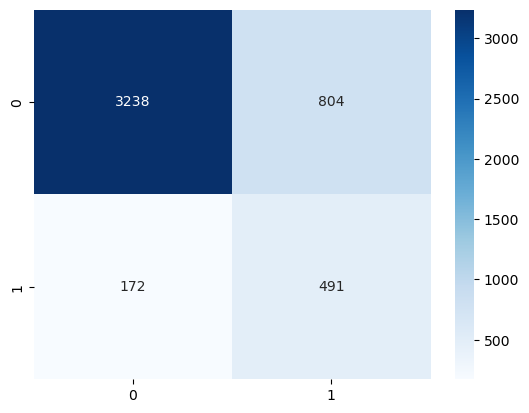

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      4042
           1       0.38      0.74      0.50       663

    accuracy                           0.79      4705
   macro avg       0.66      0.77      0.69      4705
weighted avg       0.87      0.79      0.82      4705



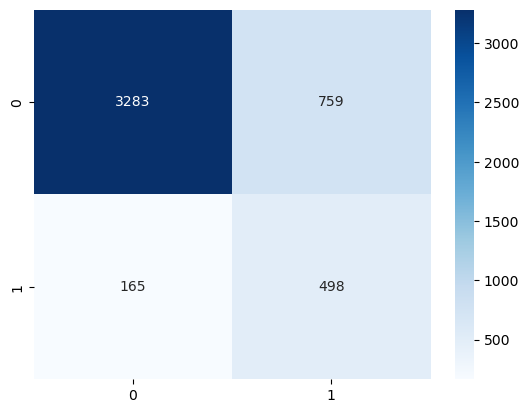

              precision    recall  f1-score   support

           0       0.95      0.81      0.88      4042
           1       0.40      0.75      0.52       663

    accuracy                           0.80      4705
   macro avg       0.67      0.78      0.70      4705
weighted avg       0.87      0.80      0.83      4705



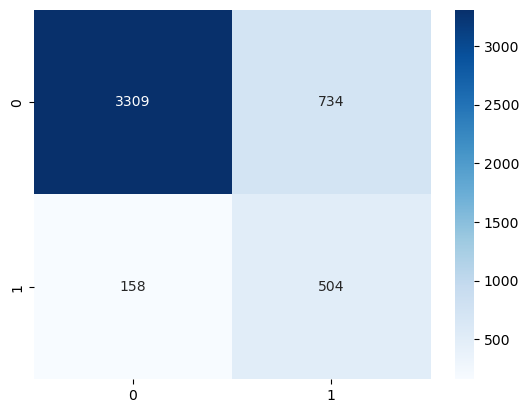

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      4043
           1       0.41      0.76      0.53       662

    accuracy                           0.81      4705
   macro avg       0.68      0.79      0.71      4705
weighted avg       0.88      0.81      0.83      4705



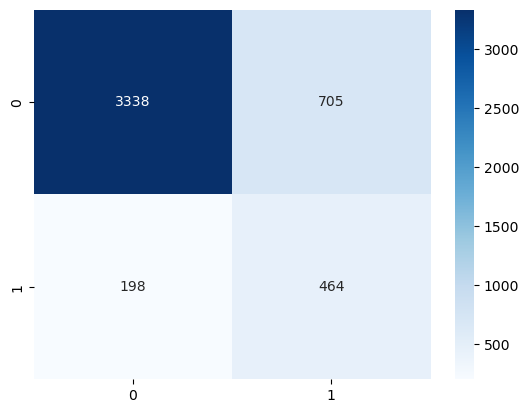

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      4043
           1       0.40      0.70      0.51       662

    accuracy                           0.81      4705
   macro avg       0.67      0.76      0.69      4705
weighted avg       0.87      0.81      0.83      4705



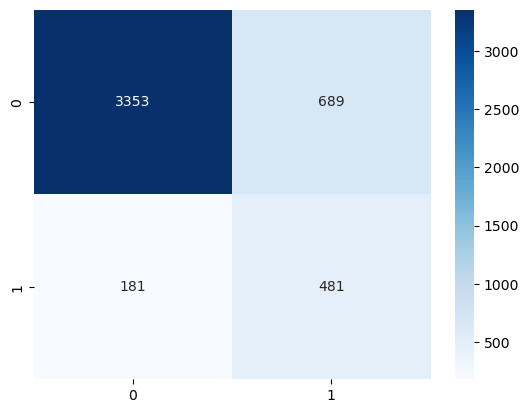

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      4042
           1       0.41      0.73      0.53       662

    accuracy                           0.82      4704
   macro avg       0.68      0.78      0.71      4704
weighted avg       0.87      0.82      0.83      4704



In [19]:
model = RandomForestClassifier(random_state=0, criterion='log_loss', n_estimators=500, max_depth=10, class_weight='balanced_subsample', max_features='log2')
scores, model_obj = create_model(model, X_n, y)

In [20]:
display(scores)
print(f'Average AUC-ROC score of RandomForest model is {sum(scores)/len(scores)}')

[0.7708308611763512,
 0.7816764470794217,
 0.789890474977078,
 0.7632654403231725,
 0.7780629672427427]

Average AUC-ROC score of RandomForest model is 0.7767452381597532


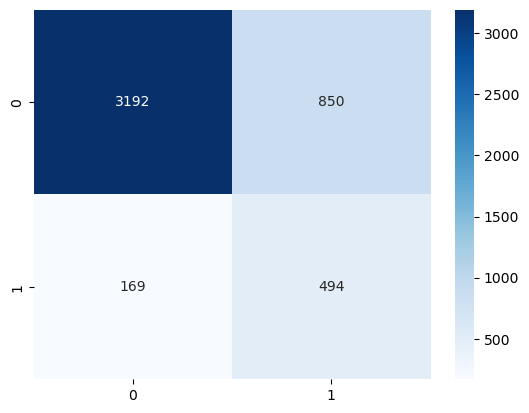

              precision    recall  f1-score   support

           0       0.95      0.79      0.86      4042
           1       0.37      0.75      0.49       663

    accuracy                           0.78      4705
   macro avg       0.66      0.77      0.68      4705
weighted avg       0.87      0.78      0.81      4705



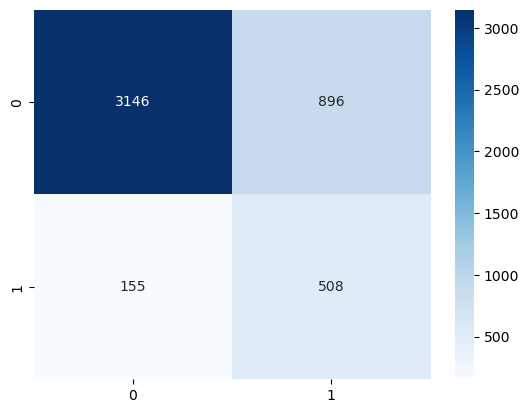

              precision    recall  f1-score   support

           0       0.95      0.78      0.86      4042
           1       0.36      0.77      0.49       663

    accuracy                           0.78      4705
   macro avg       0.66      0.77      0.67      4705
weighted avg       0.87      0.78      0.81      4705



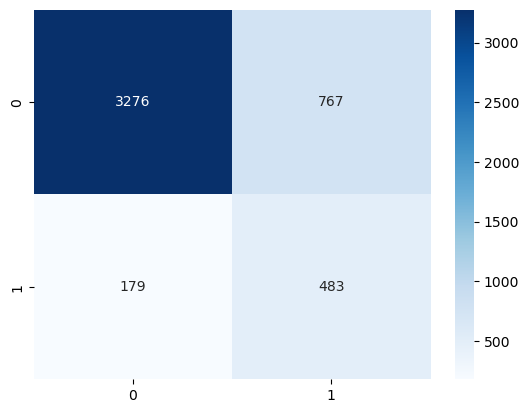

              precision    recall  f1-score   support

           0       0.95      0.81      0.87      4043
           1       0.39      0.73      0.51       662

    accuracy                           0.80      4705
   macro avg       0.67      0.77      0.69      4705
weighted avg       0.87      0.80      0.82      4705



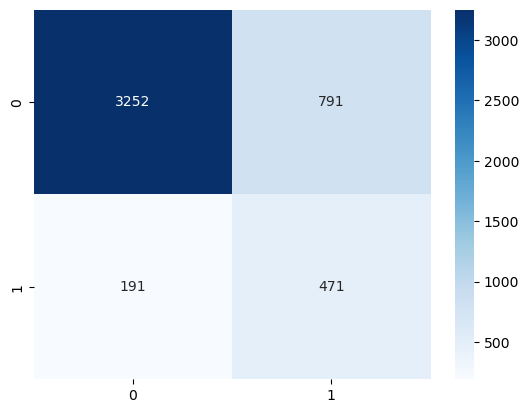

              precision    recall  f1-score   support

           0       0.94      0.80      0.87      4043
           1       0.37      0.71      0.49       662

    accuracy                           0.79      4705
   macro avg       0.66      0.76      0.68      4705
weighted avg       0.86      0.79      0.82      4705



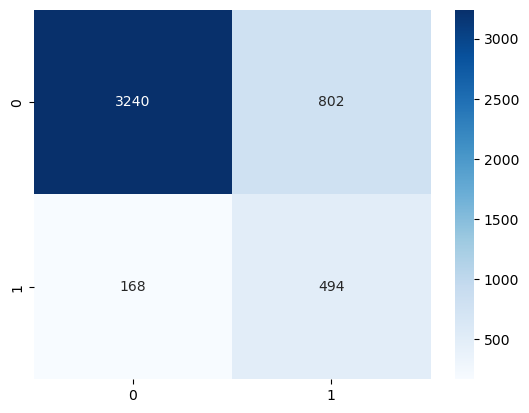

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      4042
           1       0.38      0.75      0.50       662

    accuracy                           0.79      4704
   macro avg       0.67      0.77      0.69      4704
weighted avg       0.87      0.79      0.82      4704



In [21]:
lr = LogisticRegression(solver='saga', class_weight='balanced', random_state=0, max_iter=1000)
lr_scores, lr_obj = create_model(lr, X_n, y)

In [22]:
display(lr_scores)
print(f'Average AUC-ROC score of LogisticRegression model is {sum(lr_scores)/len(lr_scores)}')

[0.7674030522649435,
 0.7722708692962207,
 0.7699483199114054,
 0.7579167828023969,
 0.7739034697608643]

Average AUC-ROC score of LogisticRegression model is 0.7682884988071662
